In [264]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [265]:
df = pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [266]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Changing all columns names to lower case

In [267]:
df.columns = df.columns.str.lower()

1. Data cleaning including missing values, outliers and multi-collinearity. 

Missing Values

In [268]:
missing_val = df.isnull().sum()
missing_val

step              0
type              0
amount            0
nameorig          0
oldbalanceorg     0
newbalanceorig    0
namedest          0
oldbalancedest    0
newbalancedest    0
isfraud           0
isflaggedfraud    0
dtype: int64

### No Missing values. Therefore, no need of dropping missing values
Multi-collinearity

In [269]:
le = LabelEncoder()
df_new = df.copy(deep=True)
df_new['type'] = le.fit_transform(df_new['type'])
df_new = df_new.drop(columns=['nameorig', 'namedest', 'isfraud', 'isflaggedfraud'])
df_new.head()

,step,type,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest
0,1,3,9839.64,170136.0,160296.36,0.0,0.0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0
2,1,4,181.00,181.0,0.00,0.0,0.0
3,1,1,181.00,181.0,0.00,21182.0,0.0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0


Evaluating VIF for multicollinearity assessment among variables.

In [270]:
corr_matrix = df_new.corr()
inv_corr_matrix = np.linalg.inv(corr_matrix.values)
vif = pd.DataFrame({'Features': df_new.columns, 'VIF': np.diag(inv_corr_matrix)})
vif

,Features,VIF
0,step,1.002443
1,type,1.268177
2,amount,3.713504
3,oldbalanceorg,459.068772
4,newbalanceorig,464.180601
5,oldbalancedest,65.950912
6,newbalancedest,75.773973


Oldbalance and newbalance exhibit significantly elevated VIF values, suggesting a strong correlation. Given the inherent value changes during transactions, combining these features results in a model with substantial multicollinearity.

### Identify fraudulent transactions by using the `isFraud` function to determine their type.
There are two flags: `isFraud` signals actual fraud transactions, while `isFlaggedFraud` indicates transactions prevented by the system due to triggered thresholds.


In [271]:
fraud_data = df[df.isfraud == 1]

fraud_transfer = fraud_data[fraud_data.type == 'TRANSFER']
fraud_cashout = fraud_data[fraud_data.type == 'CASH_OUT']

print('Type of transactions which are fraud: {}'.format(fraud_data.type.unique()))
print('Number of transfer transactions that are fraud: {}'.format(len(fraud_transfer)))
print('Number of cashout transactions that are fraud: {}'.format(len(fraud_cashout)))


Type of transactions which are fraud: ['TRANSFER' 'CASH_OUT']
Number of transfer transactions that are fraud: 4097
Number of cashout transactions that are fraud: 4116


### Evaluate the `isFlaggedFraud` variable.
The business model, encapsulated in `isFlaggedFraud`, focuses on overseeing significant fund transfers, detecting and flagging any illicit transactions exceeding 200,000 in value within the dataset.

In [272]:
flagged_fraud_data = df[df.isflaggedfraud == 1]
non_flagged_fraud_data = df[df.isflaggedfraud == 0]

print('Minimum amount transfer where isFlaggedFraud is 1: {}'.format(flagged_fraud_data.amount.min()))
print('Maximum amount transfer where isFlaggedFraud is 0: {}'.format(non_flagged_fraud_data.amount.max()))
print('Number of isFlaggedFraud == 1: {}'.format(flagged_fraud_data.shape[0]))


Minimum amount transfer where isFlaggedFraud is 1: 353874.22
Maximum amount transfer where isFlaggedFraud is 0: 92445516.64
Number of isFlaggedFraud == 1: 16


The `isFlaggedFraud` variable becomes redundant as it is set to 1 only when the transfer exceeds 200,000, yet the analysis reveals the maximum single transaction is 92,445,516.64. With just 16 instances of `isFlaggedFraud` being set, we opt to eliminate this feature.

Both `oldbalanceorg` and `newbalanceorig` variables

Due to a transaction being on hold, both the new balanced set and old balance destination exhibit zero values in the analysis, indicating a lack of information for merchants.

In [273]:
zero_balance_recipients = df[(df.newbalancedest == 0) & (df.oldbalancedest == 0)]
print('Number of recipients with newbalancedest and oldbalancedest as zero: {}'.format(zero_balance_recipients.shape[0]))

Number of recipients with newbalancedest and oldbalancedest as zero: 2317282


Upon analyzing, it appears there is a transaction amount, yet both odlbalanceorig and newbalanceorig remain at zero. This contradiction suggests potential errors or missing values in these variables, as transactions typically involve changes in balances.

In [274]:
non_zero_amount_zero_balance_transactions = df[(df.oldbalanceorg == 0) & (df.newbalanceorig == 0) & (df.amount != 0)]
print('Number of transactions where oldbalanceorig and newbalanceorig are zero, but amount is not zero: {}'.format(non_zero_amount_zero_balance_transactions.shape[0]))

Number of transactions where oldbalanceorig and newbalanceorig are zero, but amount is not zero: 2088969


### Determine the number of merchant accounts within originator accounts and assess if there are any instances of fraudulent transactions in merchant accounts.
<ol type=i>
<li>`oldbalanceDest` - Ensure recipient's initial balance precedes the transaction; no details available for customers beginning with `M` (Merchants). </li>
<li>`newbalanceDest` - After the transaction, the recipient of the new balance is designated. Please be aware that there is no information available for customers with names starting with `M` (Merchants). </li>

In [275]:
print('Number of merchants in originator transactions: {}'.format((df.nameorig.str.contains('M')).any().sum()))
print('Number of merchant accounts in destination where type is Transfer: {}'.format((df.loc[df.type == 'TRANSFER', 'namedest'].str.contains('M')).any().sum()))
print('Number of merchant accounts in destination where type is Cashout: {}'.format((df.loc[df.type == 'CASH_OUT', 'namedest'].str.contains('M')).any().sum()))

Number of merchants in originator transactions: 0
Number of merchant accounts in destination where type is Transfer: 0
Number of merchant accounts in destination where type is Cashout: 0


No fraudulent transactions occur since there are no merchant accounts, ensuring that missing information has no impact on model development.

2. Describe your fraud detection model in elaboration.

A preliminary strategy to address imbalanced data involves equalizing it by discarding the majority class before applying a machine learning (ML) algorithm. However, undersampling has its drawbacks as a model trained this way may struggle with real-world skewed test data due to significant information loss. An alternative and more effective approach is to oversample the minority class, perhaps through the synthetic minority oversampling technique (SMOTE) available in the `imblearn` library. <br>

Motivated by this, I experimented with various anomaly-detection and supervised learning methods. Despite these attempts, I observed that the most favorable outcome was achieved using the original dataset with an ML algorithm based on ensembles of decision trees. These algorithms inherently perform well on imbalanced data, not only accommodating missing values in the data but also facilitating speedup through parallel processing. <br>

Among the ensemble algorithms, I found that the extreme gradient-boosted (XGBoost) algorithm yielded the best results. In conclusion, XGBoost, like several other ML algorithms, enables the weighting of the positive class more heavily compared to the negative class. This capability is particularly valuable as it allows for addressing the data skew effectively.

3. How did you select variables to be included in the model?

Based on the analysis, fraud exclusively occurs in `TRANSFER` and `CASH_OUT` transactions. Consequently, we'll focus solely on these payment types, omitting variables `nameorig`, `namedest`, and `isFlaggedFraud` for streamlined analysis.

In [276]:
selected_types = ['TRANSFER', 'CASH_OUT']
X = df[df.type.isin(selected_types)]
y = X.isfraud

X = X.drop(['isfraud', 'isflaggedfraud', 'nameorig', 'namedest'], axis=1)

le1 = LabelEncoder()
X['type'] = le1.fit_transform(X['type'])

### Replacing missing values
Replace transactions with zero newbalanceorig and oldbalanceorig, but non-zero amount with np.nan. <br>
Both newbalancedest and oldbalancedest values are zero, indicating potential fraud; imputing them as -1 to address non-zero amount discrepancies.

In [277]:
mask_dest = (X.oldbalancedest == 0) & (X.newbalancedest == 0) & (X.amount != 0)
X.loc[mask_dest, ['oldbalancedest', 'newbalancedest']] = -1

mask_orig = (X.oldbalanceorg == 0) & (X.newbalanceorig == 0) & (X.amount != 0)
X.loc[mask_orig, ['oldbalanceorg', 'newbalanceorig']] = 0

### Feature engineering
Based on the analysis, we can identify two error features: one at the origin and another at the destination account, involving non-zero transfers with old balance and new balance both showing zero values.

In [278]:
X['errorbalanceorig'] = X['newbalanceorig'] + X['amount'] - X['oldbalanceorg']
X['errorbalancedest'] = X['oldbalancedest'] + X['amount'] - X['newbalancedest']

### Data visualization
Visualizing data is the most effective method to assess its classifiability.

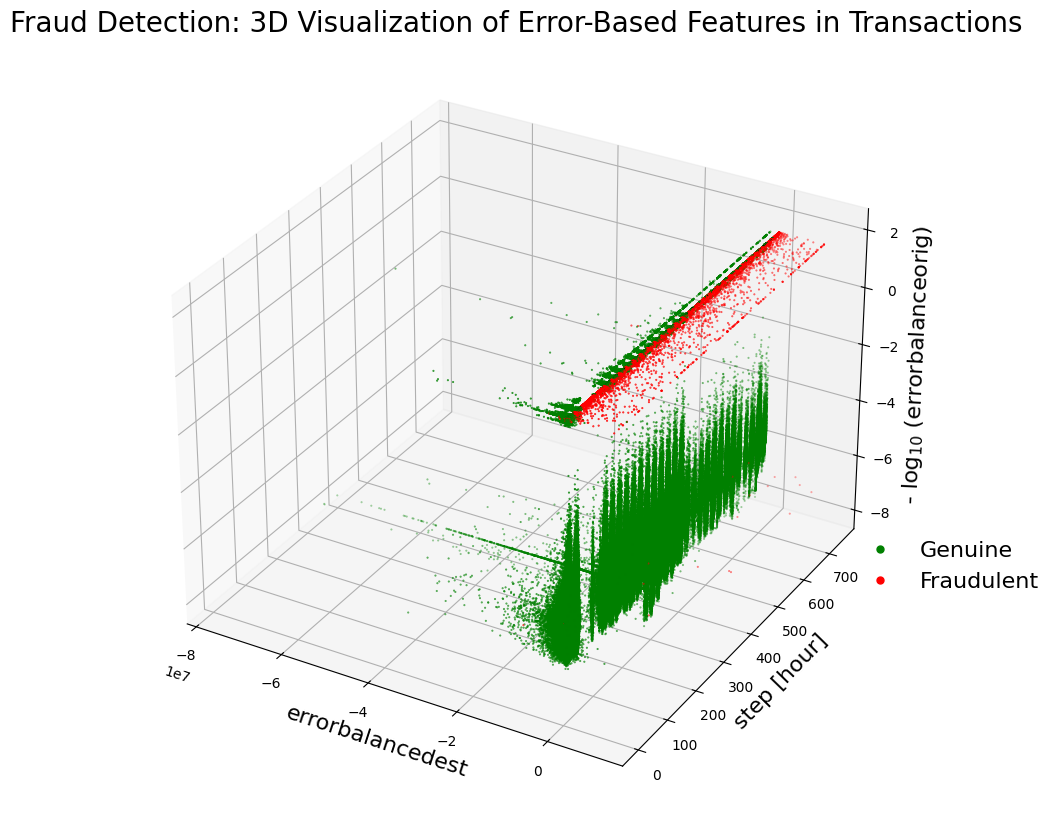

In [279]:
x1 = 'errorbalancedest'                                       
y1 = 'step'
z1 = 'errorbalanceorig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() 

fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[x1][:limit], X[y1][:limit], -np.log10(X[z1][:limit] + zOffset), c=np.where(y == 0, 'g', 'r'), marker='.', s=1, label=['Genuine', 'Fraudulent'])

ax.set_xlabel(x1, size=16)
ax.set_ylabel(y1 + ' [hour]', size=16)
ax.set_zlabel('- log$_{10}$ (' + z1 + ')', size=16)
ax.set_title('Fraud Detection: 3D Visualization of Error-Based Features in Transactions', size=20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth=0, color='g', marker='.', markersize=10, label='Genuine')
fraudMarker = mlines.Line2D([], [], linewidth=0, color='r', marker='.', markersize=10, label='Fraudulent')

plt.legend(handles=[noFraudMarker, fraudMarker], bbox_to_anchor=(1.20, 0.38), frameon=False, prop={'size': 16})
plt.show()


Our new features enable seamless data separation, as demonstrated in the visualization above.

4. Demonstrate the performance of the model by using best set of tools.

Choosing Metric: Choosing AUPRC over AUROC due to highly skewed data; it emphasizes the model's performance on the 1% positive examples, with high AUPRC indicating effective handling and low AUPRC reflecting poor performance on positives.

5. What are the key factors that predict fraudulent customer?

<ol type=i>
<li> OldbalanceOrg and newbalanceOrig exhibiting zero values while the transaction amount is non-zero. </li>
<li> OldbalanceDest and newbalanceDest exhibiting zero values while the transaction amount is non-zero. </li>
<li> Transactions where both oldbalanceDest and newbalanceDest exhibit zero values. </li>
<li> Transactions where both oldbalanceOrg and newbalanceOrig are zero but the amount is not zero, indicating potential errors or issues. </li>
<li> The customer’s identity, including email addresses, credit card numbers, etc. </li>
<li> The past order details, preferred payment methods, locations used for transactions, and network. </li>
</ol>

6. Do these factors make sense? If yes, How? If not, How not? 

These factors make sense as they are related to financial transactions and can be used to identify fraudulent activities. For example, transactions where both oldbalanceDest and newbalanceDest exhibit zero values indicate potential fraud. Similarly, the customer’s identity and past order details can be used to detect fraudulent activities. However, it is important to note that these factors are not exhaustive and other factors may also be relevant in predicting fraudulent customers.

### Predicting fraudulent transactions using machine learning.
Assessing data for imbalance or skew.

In [280]:
fraud_count = y.value_counts()[1]
not_fraud_count = y.value_counts()[0]

print('Fraud Counts:',fraud_count)
print('Non Fraud Counts:', not_fraud_count)

Fraud Counts: 8213
Non Fraud Counts: 2762196


In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [282]:
imbalance_ratio = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())

clf = XGBClassifier(max_depth=3, scale_pos_weight=imbalance_ratio, n_jobs=4)
probabilities = clf.fit(X_train, y_train).predict_proba(X_test)
auprc = average_precision_score(y_test, probabilities[:, 1])

print('AUPRC = {}'.format(auprc))

AUPRC = 0.9929583567718446


The AUPRC score of 0.99 indicates that our model is demonstrating strong performance on the positive class, specifically in identifying fraudulent transactions.

7. What kind of prevention should be adopted while company update its infrastructure?

<ol type=i>
<li>To enhance fraud prevention measures, companies should prioritize scrutiny of specific payment methods such as `Transfer` and `Cash Out`. </li>
<li>Vigilance in identifying patterns associated with fraudulent activities and theft is crucial in safeguarding financial transactions. </li>
</ol>

8. Assuming these actions have been implemented, how would you determine if they work?

<ol type=i>
<li>Check the calculated AUPRC (Area Under the Precision-Recall Curve) value, aiming for a higher score, as it indicates improved model performance, especially for imbalanced datasets like fraud detection.</li>
<li>Inspect any visualizations to ensure genuine and fraudulent transactions are well-separated, especially in a 3D visualization. </li>
<li>Compare the AUPRC with the performance of previous models or iterations without optimizations to gauge improvement. </li>
<li>Continuous monitoring and refinement may be necessary to adapt to evolving data distributions over time.</li>
</ol>